# Predicting the NBA MVP with Machine Learning

The goal of this analysis is to predict the NBA MVP for a given year, based on NBA player data and MVP voting data in other years. This is accomplished by applying several machine learning regression algorithms on NBA player performance data. The analysis is based on the [Scikit-learn](http://scikit-learn.org) machine learning package, NBA data are taken from [basketball-reference.com](https://www.basketball-reference.com).

## Import modules and libraries:

In [1]:
import NBAanalysissetup # See NBAanalysissetup.py

from NBAanalysissetup import MyModel, MyCM

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns

import operator
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.neighbors        import KNeighborsRegressor
from sklearn.linear_model     import Ridge, Lasso, ElasticNet, SGDRegressor, PassiveAggressiveRegressor
from sklearn.linear_model     import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm              import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree             import DecisionTreeRegressor
from sklearn.ensemble         import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.ensemble         import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network   import MLPRegressor

from xgboost                  import XGBRegressor

from sklearn.model_selection import validation_curve, LeaveOneGroupOut, GridSearchCV

from sklearn.metrics import explained_variance_score, median_absolute_error, mean_absolute_error 
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

%load_ext watermark
%watermark -a "Author: gmalim" 
print("")
%watermark -u -n
print("")
%watermark -v -p numpy,pandas,sklearn,xgboost,matplotlib,seaborn
print("")
%watermark -m

start = time.time()

Author: gmalim

last updated: Sun Apr 22 2018

CPython 3.6.5
IPython 6.3.1

numpy 1.14.2
pandas 0.22.0
sklearn 0.19.1
xgboost 0.71
matplotlib 2.2.2
seaborn 0.8.1

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


## User input

Choose the year you want to predict (*test_year*), between 2010 and 2018. The years that are not selected are used for cross-validation and training of the ML algorithms.

In [2]:
test_year = 2018 # Enter any year from 2010 until 2018

# Check if MVP has been awarded yet for test_year:
 
shellcommand = "wc -l data/NBA_MVP_{}-{}.csv | awk '{{print $1}}'".format(test_year-1, test_year)
n = !{shellcommand}
n = int(n[0])
test_year_truth_is_known = False if n == 1 else True

if test_year_truth_is_known:
    print("--> Test year = {} (MVP has been awarded)".format(test_year))
else:
    print("--> Test year = {} (MVP has not been awarded yet)".format(test_year))
    
first_year = 2000 # First year for which data has been scraped
last_year  = 2018 # Last  year for which data has been scraped

train_years = list(range(first_year, last_year+1))

train_years.remove(test_year)

first_train_year = train_years[0]
last_train_year  = train_years[-1]
    
if (first_train_year < test_year < last_train_year):
    print("--> Train years = {}-{} except {}".format(first_train_year, last_train_year, test_year))
else:
    print("--> Train years = {}-{}".format(first_train_year, last_train_year))

--> Test year = 2018 (MVP has not been awarded yet)
--> Train years = 2000-2017


Choose whether you want to include advanced players statistics (e.g. *PER*, *VORP*, etc.) in the model or not,
and choose the minimum number of games a player has to have started per season to be included in the analysis:

In [3]:
includeadvancedstats = True # Enter True or False

if includeadvancedstats:
    print("--> Advanced statistics included")
else:
    print("--> Advanced statistics not included")
    
min_num_games = 60 # Enter any number between 0 and 82

print("--> Minimum number of games for each player =", min_num_games)

--> Advanced statistics included
--> Minimum number of games for each player = 60


## Data processing

NBA data from 2010-2018 from [basketball-reference.com](https://www.basketball-reference.com) have been saved as csv-files in the **data** directory using the scraper functions in [NBAanalysissetup.py](NBAanalysissetup.py).

In [4]:
df_train, df_test = NBAanalysissetup.loaddata_allyears(train_years, test_year, includeadvancedstats, target='MVP')

--> Loading train year 1999-2000 ...
--> Loading train year 2000-2001 ...
--> Loading train year 2001-2002 ...
--> Loading train year 2002-2003 ...
--> Loading train year 2003-2004 ...
--> Loading train year 2004-2005 ...
--> Loading train year 2005-2006 ...
--> Loading train year 2006-2007 ...
--> Loading train year 2007-2008 ...
--> Loading train year 2008-2009 ...
--> Loading train year 2009-2010 ...
--> Loading train year 2010-2011 ...
--> Loading train year 2011-2012 ...
--> Loading train year 2012-2013 ...
--> Loading train year 2013-2014 ...
--> Loading train year 2014-2015 ...
--> Loading train year 2015-2016 ...
--> Loading train year 2016-2017 ...
--> Loading test  year 2017-2018 ...


Print table of players with MVP votes in *test_year*:

In [5]:
if test_year_truth_is_known:
    print("--> Players with MVP votes in {} :".format(test_year))
    #df_tmp = df_train[(df_train['YEAR'] == print_year) & (df_train['MVS'] > 0)]
    df_tmp = df_test[df_test['MVS'] > 0]
    cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    df_tmp_style = df_tmp.style.background_gradient(cmap=cm, axis=0)
    display(df_tmp_style)
else:
    print("--> The NBA MVP for {} has not been awarded yet".format(test_year))

--> The NBA MVP for 2018 has not been awarded yet


Select only players which have started at least *min_num_games* number of games started in a season:

In [6]:
print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])
print("")

df_train = df_train[df_train['GS'] >= min_num_games]
df_test  = df_test [df_test ['GS'] >= min_num_games]

print("--> # of players in train set =", df_train.shape[0])
print("--> # of players in test  set =", df_test .shape[0])

#df_train = df_train[df_train['MVS'] > 0]
#df_test  = df_test [df_test ['MVS'] > 0]

#print("--> # of players in train set =", df_train.shape[0])
#print("--> # of players in test  set =", df_test .shape[0])

# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players in train set = 8240
--> # of players in test  set = 540

--> # of players in train set = 1793
--> # of players in test  set = 96


NaN handling:

In [7]:
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Replace NaNs with 0s in the following columns:

df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_train[['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)
df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']] = df_test [['FG%', '3P%', '2P%', 'FT%', 'eFG%']].fillna(value=0)

if (includeadvancedstats):
    df_train[['TS%', '3PAr', 'FTr']] = df_train[['TS%', '3PAr', 'FTr']].fillna(value=0)
    df_test [['TS%', '3PAr', 'FTr']] = df_test [['TS%', '3PAr', 'FTr']].fillna(value=0)
    
print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])
print("--> # of players with NaNs in test  set =", df_test .shape[0] - df_test .dropna().shape[0])
print("")

# Remove remaining players with NaNs, if necessary:

if (df_train.shape[0] - df_train.dropna().shape[0] != 0):
    #print("--> Players in train set with NaNs:")
    #print(df_train[df_train.isnull().any(axis=1)])
    #print("")
    df_train.dropna(inplace=True)
    print("--> # of players with NaNs in train set =", df_train.shape[0] - df_train.dropna().shape[0])

if (df_test.shape[0] - df_test.dropna().shape[0] != 0):
    #print("--> Players in test set with NaNs:")
    #print(df_test[df_test.isnull().any(axis=1)])
    #print("")
    df_test.dropna(inplace=True)
    print("--> # of players with NaNs in test  set =", df_test.shape[0] - df_test.dropna().shape[0])
    
# Reset dataframe indices:

df_train = df_train.reset_index(drop=True)
df_test  = df_test .reset_index(drop=True)

--> # of players with NaNs in train set = 97
--> # of players with NaNs in test  set = 2

--> # of players with NaNs in train set = 0
--> # of players with NaNs in test  set = 0



Prepare data and create Feature Matrix (*X*) and Target Vector (*y*) dataframes:

In [8]:
# Feature Matrix dataframes:

X_train = df_train.drop(['MVS', 'YEAR'], axis=1) # MVS and YEAR are dropped: MVS is the target variable,
X_test  = df_test .drop(['MVS', 'YEAR'], axis=1) # YEAR is only used for cross-validation (see below).

X_list = [X_train, X_test]

for X in X_list:
    
    # Remove redundant features:
    
    # - Features with no predictive power 
    # - Features that are correlated with other features
    # - Features that measure the same performance skill
    
    X.drop(['Player', 'Pos', 'Tm', 'Age', 'TC',     
            'FG', 'FGA', 'FG%', '2P', '2PA', '2P%', 
            '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 
            'ORB', 'DRB', 'PF'],                    
           axis=1, inplace=True)

    if includeadvancedstats:
        X.drop(['3PAr', 'FTr', 'ORB%', 'DRB%', 'TOV%', 'WS', 'WS/48', 'BPM', 
                'eFG%', 'TRB', 'AST', 'STL', 'BLK', 'TOV'], 
               axis=1, inplace=True) 
    
    # Scale total-type features by MP/48:
    
    X[['PTS']] = X[['PTS']].div(X['MP'].values, axis=0)
    X[['PTS']] = X[['PTS']].multiply(48, axis=0)
    X.rename(columns={'PTS': 'PTS/48'}, inplace=True)
    
    if includeadvancedstats:
        X[['OWS', 'DWS']] = \
        X[['OWS', 'DWS']].div(X['MP'].values, axis=0)
        X[['OWS', 'DWS']] = X[['OWS', 'DWS']].multiply(48, axis=0)
        X.rename(columns={'OWS': 'OWS/48', 'DWS': 'DWS/48'}, inplace=True)
    else:
        X[['TRB', 'AST', 'STL', 'BLK']] = X[['TRB', 'AST', 'STL', 'BLK']].div(X['MP'].values, axis=0)
        X[['TRB', 'AST', 'STL', 'BLK']] = X[['TRB', 'AST', 'STL', 'BLK']].multiply(48, axis=0)
        X.rename(columns={'TRB': 'TRB/48', 'AST': 'AST/48', 'STL': 'STL/48', 
                          'BLK': 'BLK/48', 'TOV': 'TOV/48'}, inplace=True)

    # Scale MP by G:

    X['MP'] = X['MP'].div(X['G'], axis=0)
    X.rename(columns={'MP': 'MP/G'}, inplace=True)
    
# Target Vector dataframes: 

y_train = df_train['MVS'] # target = MVS, a floating variable introduced to indicate players' MVP vote share
y_test  = df_test ['MVS']

n_players_train = X_train.shape[0]
n_players_test  = X_test .shape[0]
n_features = X_test.shape[1] # equals X_train.shape[1]

print("--> Train data set : # of players = {:4}, # of features = {}".format(n_players_train, n_features))
print("--> Test  data set : # of players = {:4}, # of features = {}".format(n_players_test,  n_features))
print("")
print("--> Model features : ", end = '')
print(*X_train.columns, sep=', ')

--> Train data set : # of players = 1793, # of features = 17
--> Test  data set : # of players =   96, # of features = 17

--> Model features : G, GS, MP/G, PTS/48, PER, TS%, TRB%, AST%, STL%, BLK%, USG%, OWS/48, DWS/48, OBPM, DBPM, VORP, TW


Explore relationship between MVS and other features in training data:

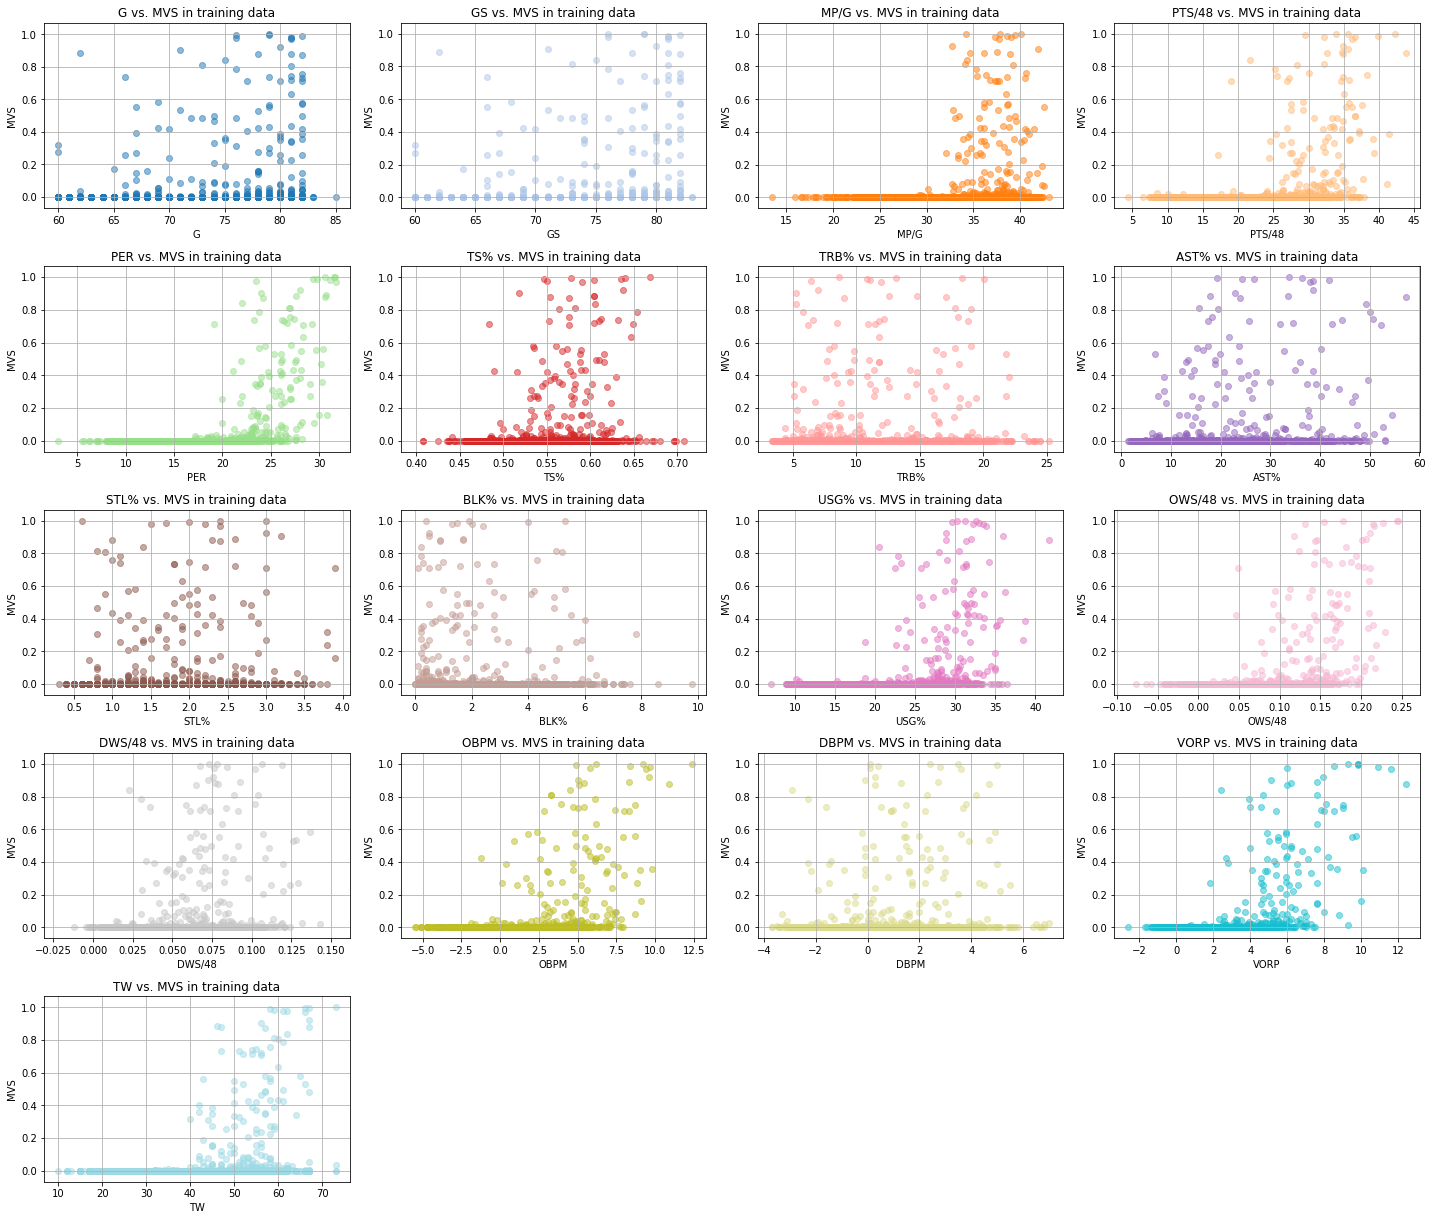

In [9]:
color=iter(plt.cm.tab20(np.linspace(0, 1, len(X_train.columns))))    

plt.figure(figsize=(20, 20))

for ifeature, feature in enumerate(X_train.columns):

    plt.subplot(6, 4, ifeature+1)

    plt.title("{} vs. MVS in training data".format(feature))
    plt.xlabel(feature)
    plt.ylabel('MVS')
    plt.scatter(X_train[feature], y_train, color=next(color), alpha=0.5)
    plt.grid(True)
    plt.tight_layout()

Scale feature dataframes to accommodate ML algorithms:

In [10]:
feature_names = X_train.columns # This is no longer available after transformation with scaler

#X_scaler = StandardScaler(with_mean=True, with_std=True) # Scaler with zero mean and unit variance
#X_scaler = MinMaxScaler() # Scales features to range 0 to 1 (or -1 to 1 if there are negative values)
X_scaler = RobustScaler() # Similar method to the MinMaxScaler but more robust to outliers

X_train = X_scaler.fit_transform(X_train) # Fit scaler to training data and transform X_train
X_test  = X_scaler.transform(X_test)      # Transform X_test using fitted scaler

## Supervised Learning

Select ML regressors, set hyper-parameters and instantiate models:

In [11]:
rseed = 666 # Set random_state of model (where applicable) to specific seed, to tune hyper-parameters

models = []

estimator_name = 'K-Nearest Neighbours Regressor'
n_n = 10
w   = 'uniform' # 'uniform', 'distance'
estimator = KNeighborsRegressor(n_neighbors=n_n, weights=w)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Ridge Regressor' # Shrinkage => Feature coefficient suppression
a = 0.1 # regularization factor (higher alpha -> stronger regularization i.e. opposite of C parameter)
estimator = Ridge(alpha=a, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Lasso Regressor' # Sparsity => Feature selection
a = 1e-05
estimator = Lasso(alpha=a, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'ElasticNet Regressor' # Shrinkage & Sparsity
a = 1e-04
l_r = 0.5
estimator = ElasticNet(alpha=a, l1_ratio=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Support Vector Machine Regressor'
#estimator_name = 'Linear Support Vector Machine Regressor'
C = 0.1
e = 0.1
k = 'poly' # 'linear'
d = 3 # only used by poly kernel
estimator = SVR(C=C, epsilon=e, kernel=k, degree=d, cache_size=1000)
#l = 'epsilon_insensitive' # i.e. l1 regularizarion -> Sparsity
#l = 'squared_epsilon_insensitive' # i.e. l2 regularizarion -> Shrinkage 
#estimator = LinearSVR(C=C, loss=l, dual=False, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Stochastic Gradient Descent Regressor'
l = 'squared_loss' # 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'
p = 'l2' # 'l1', 'elasticnet'
a = 0.01
l_r = 0.15 # only for elasticnet penalty
estimator = SGDRegressor(loss=l, penalty=p, alpha=a, l1_ratio=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Passive Aggressive Regressor'
C = 0.001
l = 'epsilon_insensitive' # 'squared_epsilon_insensitive'
e = 0.1
estimator = PassiveAggressiveRegressor(C=C, loss=l, epsilon=e, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Neural Network Regressor'
a = 1.0 # l2 regularization factor
estimator = MLPRegressor(alpha=a, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gaussian Process Regressor' # (CV is slowwwwwwww)
estimator = GaussianProcessRegressor(random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Decision Tree Regressor'
m_d = None   # i.e. nodes are expanded until leafs are pure 
m_f = 'auto' # The number of features to consider when looking for the best split. 
#              'auto' => max_features=n_features 
estimator = DecisionTreeRegressor(max_depth=m_d, max_features=m_f, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Random Forest Regressor'
n_e = 100
m_d = None
m_f = 'auto'
estimator = RandomForestRegressor(n_estimators=n_e, max_depth=m_d, max_features=m_f, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extra Randomized Trees Regressor'
n_e = 100
m_d = None
m_f = 'auto'
estimator = ExtraTreesRegressor(n_estimators=n_e, max_depth=m_d, max_features=m_f, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Adaptive Boosted Decision Tree Regressor'
n_e = 100
l_r = 0.1
estimator = AdaBoostRegressor(n_estimators=n_e, learning_rate=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Gradient Boosted Decision Tree Regressor'
n_e = 100
m_d = 3
l_r = 0.1
estimator = GradientBoostingRegressor(n_estimators=n_e, max_depth=m_d, learning_rate=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

estimator_name = 'Extreme Gradient Boosted Decision Tree Regressor'
n_e = 100
m_d = 3
l_r = 0.1
estimator = XGBRegressor(n_estimators=n_e, max_depth=m_d, learning_rate=l_r, random_state=rseed)
models.append(MyModel(estimator_name, estimator))

print("--> ML regressors implemented in this analysis:")
print("")

model_names = []

for counter, model in enumerate(models, 0):
    print("{:2} : {}".format(counter, model.estimator_name))
    #print("     Model parameters : ", mymodel.estimator.get_params())
    model_names.append(model.estimator_name)

--> ML regressors implemented in this analysis:

 0 : K-Nearest Neighbours Regressor
 1 : Ridge Regressor
 2 : Lasso Regressor
 3 : ElasticNet Regressor
 4 : Support Vector Machine Regressor
 5 : Stochastic Gradient Descent Regressor
 6 : Passive Aggressive Regressor
 7 : Neural Network Regressor
 8 : Gaussian Process Regressor
 9 : Decision Tree Regressor
10 : Random Forest Regressor
11 : Extra Randomized Trees Regressor
12 : Adaptive Boosted Decision Tree Regressor
13 : Gradient Boosted Decision Tree Regressor
14 : Extreme Gradient Boosted Decision Tree Regressor


## Cross-validation

Cross-validate the model using training data and the *LeaveOneGroupOut* cross-validation scheme in which a group is defined as a single NBA season.

In [12]:
logo = LeaveOneGroupOut()

cv_groups = df_train['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

Use *GridSearchCV* to tune hyperparameters:

Calculate and plot validation curves for specific models:

--> Plotting validation curves for Support Vector Machine Regressor ...


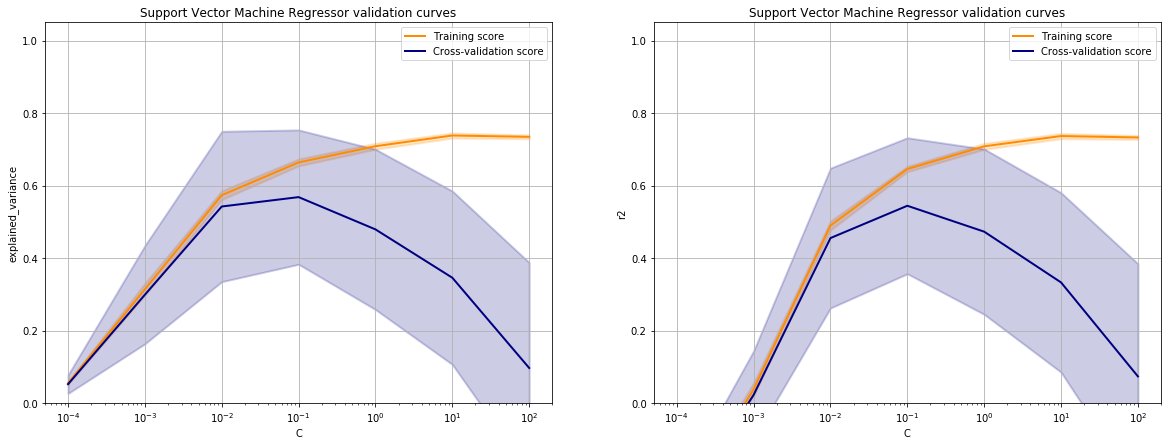

In [13]:
model = models[4]

regressor = model.estimator

print("--> Plotting validation curves for", model.estimator_name, "...")

min_logspace = -4
max_logspace =  2
param_range = np.logspace(min_logspace, max_logspace, (abs(min_logspace)+abs(max_logspace)+1))
#param_range = [2,4,6,8,10] #[3, 7, 11, 15]
#param_name = 'n_neighbors'
#param_name = 'alpha'
param_name = 'C'
#param_name = 'epsilon'
#param_name = 'max_depth'

plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)

scoring_metric = 'explained_variance'

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

train_scores, test_scores = validation_curve(regressor, X_train, y_train, param_name=param_name, 
                                             param_range=param_range, cv=cv_logo, scoring=scoring_metric)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std (train_scores, axis=1)
test_scores_mean  = np.mean(test_scores,  axis=1)
test_scores_std   = np.std (test_scores,  axis=1)

plt.title("{} validation curves".format(model.estimator_name))
plt.xlabel(param_name)
plt.ylabel(scoring_metric)
plt.ylim(0.0, 1.05)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
#plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.2, color="darkorange", lw=2)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
#plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.2, color="navy", lw=2)
plt.grid(True)
plt.legend(loc="best");

plt.subplot(1, 2, 2)

scoring_metric = 'r2'

cv_logo = logo.split(X_train, y_train, groups=cv_groups)

train_scores, test_scores = validation_curve(regressor, X_train, y_train, param_name=param_name, 
                                             param_range=param_range, cv=cv_logo, scoring=scoring_metric)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std (train_scores, axis=1)
test_scores_mean  = np.mean(test_scores,  axis=1)
test_scores_std   = np.std (test_scores,  axis=1)

plt.title("{} validation curves".format(model.estimator_name))
plt.xlabel(param_name)
plt.ylabel(scoring_metric)
plt.ylim(0.0, 1.05)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
#plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                 alpha=0.2, color="darkorange", lw=2)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
#plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                 alpha=0.2, color="navy", lw=2)
plt.grid(True)
plt.legend(loc="best");

Calculate some regression metrics:

In [14]:
X_train = np.array(X_train) # To accommodate X_train = X_training[train_index] and X_test = X_training[test_index]
y_train = np.array(y_train) # To accommodate y_train = y_training[train_index] and y_test = y_training[test_index]

logo = LeaveOneGroupOut()

cv_groups = df_train['YEAR'] # Players in the same group (i.e. a single NBA season) have identical YEAR variables

cv_metrics = []

for imodel, model in enumerate(models):
    
    model.reset()
    
    regressor      = model.estimator
    regressor_name = model.estimator_name

    model.YEAR_cvgroups = train_years
    
    EVS_cvgroups   = []
    MEDAE_cvgroups = []
    MAE_cvgroups   = []
    MSE_cvgroups   = []
    MSLE_cvgroups  = []
    R2S_cvgroups   = []

    cvimportances = []

    print("--> Cross-validating", regressor_name, "...")
    
    for train_index, test_index in logo.split(X_train, y_train, groups=cv_groups):

        X_cvtrain = X_train[train_index]
        X_cvtest  = X_train[test_index]
        y_cvtrain = y_train[train_index]
        y_cvtest  = y_train[test_index]
                       
        regressor.fit(X_cvtrain, y_cvtrain)
    
        y_cvprediction = regressor.predict(X_cvtest) 
        y_cvtruth      = y_cvtest.tolist()
                
        EVS_cvgroups  .append(explained_variance_score(y_cvtruth, y_cvprediction))
        MEDAE_cvgroups.append(median_absolute_error   (y_cvtruth, y_cvprediction))
        MAE_cvgroups  .append(mean_absolute_error     (y_cvtruth, y_cvprediction))
        MSE_cvgroups  .append(mean_squared_error      (y_cvtruth, y_cvprediction))
        MSLE_cvgroups .append(mean_squared_log_error  (y_cvtruth, y_cvprediction))
        R2S_cvgroups  .append(r2_score                (y_cvtruth, y_cvprediction))
        
        if hasattr(model.estimator, "feature_importances_"):
            importances = regressor.feature_importances_
            cvimportances.append(importances)
        
    cv_metrics.append({'Estimator'  : regressor_name, 
                       'EVS mean'   : (np.mean(EVS_cvgroups)  *1).round(3),
                       'EVS std'    : (np.std (EVS_cvgroups)  *1).round(3),
                       'MedAE mean' : (np.mean(MEDAE_cvgroups)*1).round(3),
                       'R2S mean'   : (np.mean(R2S_cvgroups)  *1).round(3),
                       'R2S std'    : (np.std (R2S_cvgroups)  *1).round(3),
                       'MedAE std'  : (np.std (MEDAE_cvgroups)*1).round(3),
                       'MAE mean'   : (np.mean(MAE_cvgroups)  *1).round(3),
                       'MAE std'    : (np.std (MAE_cvgroups)  *1).round(3),
                       'MSE mean'   : (np.mean(MSE_cvgroups)  *1).round(3),
                       'MSE std'    : (np.std (MSE_cvgroups)  *1).round(3),
                       'MSLE mean'  : (np.mean(MSLE_cvgroups) *1).round(3),
                       'MSLE std'   : (np.std (MSLE_cvgroups) *1).round(3)})
    
    model.cvimportances = cvimportances
    
print("")
print("--> Regression metrics for all models (mean and std over all years):")

columnorder = ['Estimator', 'EVS mean', 'EVS std', 'R2S mean', 'R2S std', 'MedAE mean', 'MedAE std', 
               'MAE mean', 'MAE std', 'MSE mean', 'MSE std', 'MSLE mean', 'MSLE std']

df_cv_metrics = pd.DataFrame(cv_metrics, columns=columnorder)
cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
df_cv_metrics_style = df_cv_metrics.style.background_gradient(subset=['EVS mean', 'R2S mean'], 
                                                              cmap=cm, axis=0)
display(df_cv_metrics_style)

--> Cross-validating K-Nearest Neighbours Regressor ...
--> Cross-validating Ridge Regressor ...
--> Cross-validating Lasso Regressor ...
--> Cross-validating ElasticNet Regressor ...
--> Cross-validating Support Vector Machine Regressor ...
--> Cross-validating Stochastic Gradient Descent Regressor ...
--> Cross-validating Passive Aggressive Regressor ...
--> Cross-validating Neural Network Regressor ...
--> Cross-validating Gaussian Process Regressor ...
--> Cross-validating Decision Tree Regressor ...
--> Cross-validating Random Forest Regressor ...
--> Cross-validating Extra Randomized Trees Regressor ...
--> Cross-validating Adaptive Boosted Decision Tree Regressor ...
--> Cross-validating Gradient Boosted Decision Tree Regressor ...
--> Cross-validating Extreme Gradient Boosted Decision Tree Regressor ...

--> Regression metrics for all models (mean and std over all years):


,Estimator,EVS mean,EVS std,R2S mean,R2S std,MedAE mean,MedAE std,MAE mean,MAE std,MSE mean,MSE std,MSLE mean,MSLE std
0,K-Nearest Neighbours Regressor,0.561,0.167,0.555,0.17,0,0,0.021,0.006,0.007,0.003,0.004,0.002
1,Ridge Regressor,0.338,0.15,0.332,0.152,0.032,0.006,0.054,0.006,0.01,0.003,0.006,0.002
2,Lasso Regressor,0.338,0.15,0.332,0.152,0.032,0.006,0.054,0.006,0.01,0.003,0.006,0.002
3,ElasticNet Regressor,0.338,0.148,0.333,0.149,0.032,0.006,0.054,0.006,0.01,0.003,0.006,0.002
4,Support Vector Machine Regressor,0.568,0.185,0.544,0.188,0.023,0.003,0.042,0.007,0.007,0.003,0.004,0.002
5,Stochastic Gradient Descent Regressor,0.305,0.1,0.302,0.099,0.036,0.007,0.055,0.008,0.011,0.002,0.006,0.001
6,Passive Aggressive Regressor,0.279,0.092,0.272,0.09,0.039,0.008,0.058,0.008,0.011,0.002,0.007,0.001
7,Neural Network Regressor,0.612,0.182,0.606,0.184,0.007,0.001,0.027,0.005,0.006,0.003,0.003,0.002
8,Gaussian Process Regressor,0.443,0.217,0.436,0.222,0.001,0,0.024,0.006,0.009,0.005,0.005,0.003
9,Decision Tree Regressor,0.221,0.428,0.212,0.432,0,0,0.026,0.01,0.012,0.006,0.007,0.003


#### Conclusion: 

The cross-validation regression metrics indicate that not all models work well, as expected from the non-linearity between MVS and other data features. Models with an $R^2$-score lower than 0.5 are discarded for the final prediction:
- All linear regression models (*Ridge, Lasso, ElasticNet, Stochastic Gradient Descent, Passive Aggressive*)
- *Gaussian Process Regressor*
- *Decision Tree Regressor*

In [15]:
rejected_model_indices = [1,2,3,5,6,8,9]
rejected_models = []
for i in rejected_model_indices:
    rejected_models.append(models[i])
models = [x for x in models if x not in rejected_models]

Calculate feature importances of all fitted Decision Tree ensemble models (e.g. Random Forest):

In [16]:
df_importances = pd.DataFrame() #index=feature_names, columns=model_names)

for model in models:
    
    if hasattr(model.estimator, "feature_importances_"):
    
        #print("--> Calculating feature importances for", model.estimator_name, "...")
        
        cvimportances = model.cvimportances
        
        df_cvimportances = pd.DataFrame(cvimportances, columns=feature_names)
                        
        mean_cvimportances = np.mean(df_cvimportances, axis=0)
        std_cvimportances  = np.std (df_cvimportances, axis=0)
        
        for i in range(n_features):
            df_importances.loc[feature_names[i], model.estimator_name] = \
                "{:.2f} $\pm$ {:.2f}".format((mean_cvimportances[i]*100), (std_cvimportances[i]*100))

#print("")
print("--> Feature importances  of all models (mean +/- std over all CV years):")
df_importances.dropna(axis=1, how='all', inplace=True)
display(df_importances)

--> Feature importances  of all models (mean +/- std over all CV years):


,Random Forest Regressor,Extra Randomized Trees Regressor,Adaptive Boosted Decision Tree Regressor,Gradient Boosted Decision Tree Regressor,Extreme Gradient Boosted Decision Tree Regressor
G,1.14 $\pm$ 0.19,2.07 $\pm$ 0.17,0.70 $\pm$ 0.33,1.29 $\pm$ 0.45,6.20 $\pm$ 1.55
GS,1.00 $\pm$ 0.21,2.11 $\pm$ 0.14,0.45 $\pm$ 0.29,1.45 $\pm$ 0.58,0.12 $\pm$ 0.17
MP/G,2.41 $\pm$ 0.37,1.94 $\pm$ 0.20,3.36 $\pm$ 0.84,6.96 $\pm$ 1.62,9.40 $\pm$ 1.21
PTS/48,2.65 $\pm$ 0.54,5.76 $\pm$ 0.57,3.73 $\pm$ 1.72,9.24 $\pm$ 1.43,9.20 $\pm$ 1.05
PER,43.70 $\pm$ 3.48,23.80 $\pm$ 1.30,32.48 $\pm$ 3.87,11.31 $\pm$ 1.04,10.60 $\pm$ 1.02
TS%,2.83 $\pm$ 0.30,2.73 $\pm$ 0.34,1.48 $\pm$ 0.42,4.31 $\pm$ 1.15,3.83 $\pm$ 0.67
TRB%,1.66 $\pm$ 0.33,1.85 $\pm$ 0.14,1.68 $\pm$ 0.71,2.22 $\pm$ 0.74,1.76 $\pm$ 0.66
AST%,2.11 $\pm$ 0.20,2.39 $\pm$ 0.28,3.90 $\pm$ 0.92,4.79 $\pm$ 1.59,5.63 $\pm$ 0.84
STL%,1.31 $\pm$ 0.18,2.41 $\pm$ 0.24,0.71 $\pm$ 0.29,1.75 $\pm$ 0.76,2.19 $\pm$ 0.69
BLK%,1.08 $\pm$ 0.20,1.62 $\pm$ 0.16,0.68 $\pm$ 0.46,2.88 $\pm$ 0.64,2.88 $\pm$ 0.85


## Model training and predictions

Fit all models to training data and use fitted models to predict the players' MVP voting share in *test_year*. Calculate regression metrics if MVP voting has been completed for *test_year*:

In [17]:
regression_metrics = []

for model in models:
    
    regressor      = model.estimator
    regressor_name = model.estimator_name
    
    print("--> Fitting", regressor_name, "...")
    
    regressor.fit(X_train, y_train)          # Fit model to training data

    y_prediction = regressor.predict(X_test) # Predict test data
    
    model.set_y_prediction(y_prediction)
    
    if test_year_truth_is_known:

        #y_score = regressor.score(X_test, y_test) # i.e. r2 score
        #model.set_y_score(y_score)
    
        y_truth = y_test.tolist()
        model.set_y_truth(y_truth)
                
        explained_variance_s = explained_variance_score(y_truth, y_prediction)
        median_absolute_e    = median_absolute_error(y_truth, y_prediction)
        mean_absolute_e      = mean_absolute_error(y_truth, y_prediction)
        mean_squared_e       = mean_squared_error(y_truth, y_prediction)
        mean_squared_log_e   = mean_squared_log_error(y_truth, y_prediction)
        r2_s                 = r2_score(y_truth, y_prediction)
        
        regression_metrics.append({'Estimator'                : regressor_name, 
                                   'Explained Variance Score' : explained_variance_s .round(3),
                                   'R2 Score'                 : r2_s                 .round(3),
                                   'Median Absolute Error'    : median_absolute_e    .round(3),
                                   'Mean Absolute Error'      : mean_absolute_e      .round(3),
                                   'Mean Squared Error'       : mean_squared_e       .round(3),
                                   'Mean Squared Log Error'   : mean_squared_log_e   .round(3)})
    
if test_year_truth_is_known:
    print("")
    print("--> Regression metrics for all models:")
    columnorder = ['Estimator', 'Explained Variance Score', 'R2 Score', 'Median Absolute Error', 
                   'Mean Absolute Error', 'Mean Squared Error', 'Mean Squared Log Error']
    df_regression_metrics = pd.DataFrame(regression_metrics, columns=columnorder)
    cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    df_regression_metrics_style = df_regression_metrics.style.background_gradient( \
        subset=['Explained Variance Score', 'R2 Score'], cmap=cm, axis=0)
    display(df_regression_metrics_style)

--> Fitting K-Nearest Neighbours Regressor ...
--> Fitting Support Vector Machine Regressor ...
--> Fitting Neural Network Regressor ...
--> Fitting Random Forest Regressor ...
--> Fitting Extra Randomized Trees Regressor ...
--> Fitting Adaptive Boosted Decision Tree Regressor ...
--> Fitting Gradient Boosted Decision Tree Regressor ...
--> Fitting Extreme Gradient Boosted Decision Tree Regressor ...


List top MVP candidates for all models, and add predicted MVS and corresponding ranks to *df_test*:

In [18]:
player_index_dict = {}

for i in range(n_players_test):
    player_name = df_test.iat[i,0]
    player_index_dict[player_name] = i

for imodel, model in enumerate(models):
            
    model_acronym = ''.join(c for c in model.estimator_name if c.isupper())
    column_name_score = '{} score'.format(model_acronym)
    column_name_rank  = '{} rank' .format(model_acronym)
    
    df_rank = pd.DataFrame(columns=['Player', column_name_rank], index=range(0,n_players_test))

    regressor    = model.estimator
    y_prediction = model.y_prediction
    
    df_test[column_name_score] = y_prediction
    
    player_score_dict = {}
    for i in range(n_players_test):
        player_score_dict[df_test.iat[i,0]] = y_prediction[i]

    sorted_player_score_dict = sorted(player_score_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    printlimit = 10
    
    print("==> Predicted top-{} MVP vote shares in {} for {}:".format( \
        printlimit, test_year, model.estimator_name))
    print("")
    
    previous_rank  = 0
    previous_score = 1e10
    rank_increment = 0
    
    for i, (key, value) in enumerate(dict(sorted_player_score_dict).items(), 1):
        
        if (value < previous_score):
            rank = previous_rank + 1 + rank_increment
            rank_increment = 0
        else:
            rank = previous_rank
            rank_increment += 1
        previous_rank  = rank
        previous_score = value
        
        df_rank.loc[player_index_dict[key], 'Player'        ] = key
        df_rank.loc[player_index_dict[key], column_name_rank] = rank
        
        if (i <= printlimit):
            print("----> {:3}: {:24} = {:6.3f}".format(rank, key, value))
            
    df_test = pd.merge(df_test, df_rank, how='right', left_on=['Player'], right_on=['Player'])    
    print("")

==> Predicted top-10 MVP vote shares in 2018 for K-Nearest Neighbours Regressor:

---->   1: James Harden             =  0.725
---->   2: LeBron James             =  0.531
---->   3: Kevin Durant             =  0.247
---->   4: Anthony Davis            =  0.215
---->   5: Giannis Antetokounmpo    =  0.197
---->   6: Kyrie Irving             =  0.147
---->   7: Russell Westbrook        =  0.127
---->   8: Damian Lillard           =  0.074
---->   9: Nikola Jokic             =  0.040
---->  10: LaMarcus Aldridge        =  0.034

==> Predicted top-10 MVP vote shares in 2018 for Support Vector Machine Regressor:

---->   1: James Harden             =  0.857
---->   2: LeBron James             =  0.406
---->   3: Anthony Davis            =  0.238
---->   4: Russell Westbrook        =  0.202
---->   5: Damian Lillard           =  0.176
---->   6: Giannis Antetokounmpo    =  0.162
---->   7: Kevin Durant             =  0.149
---->   8: Kyrie Irving             =  0.140
---->   9: Joel Embiid 

Create MVP candidate list with all MVS predictions and prediction ranks, sorted according to the median predicted rank over all models:

In [19]:
score_column_names = []
rank_column_names  = []
both_column_names  = []

for imodel in range(len(models)):
    model_acronym = ''.join(c for c in models[imodel].estimator_name if c.isupper())
    score_column_names.append("{} score".format(model_acronym))
    rank_column_names .append("{} rank" .format(model_acronym))
    both_column_names .append("{} score".format(model_acronym))
    both_column_names .append("{} rank" .format(model_acronym))

all_column_names = ['Player', 'Tm', 'G']
all_column_names.extend(both_column_names)

df_mvp = df_test.filter(all_column_names, axis=1)

'''
# Scale all probability scores between 0 and 1:

scaler = MinMaxScaler(feature_range=(0, 1))

df_mvp[score_column_names] = scaler.fit_transform(df_mvp[score_column_names])

# Scale all probability score ranks between 1 and n_players_test:

scaler = MinMaxScaler(feature_range=(1, n_players_test))

df_mvp[rank_column_names] = scaler.fit_transform(df_mvp[rank_column_names])
'''

# Calculate median predicted MVS and median predicted rank of all non-rejected models:

df_test['Median MVS' ] = df_mvp[score_column_names].median(axis=1)
df_test['Median rank'] = df_mvp[rank_column_names ].median(axis=1)

df_mvp['Median MVS' ] = df_mvp[score_column_names].median(axis=1)
df_mvp['Median rank'] = df_mvp[rank_column_names ].median(axis=1)

if test_year_truth_is_known:
    df_mvp['MVS'] = df_test['MVS']

#df_mvp = df_mvp.sort_values('Median MVS',  ascending=False)
df_mvp = df_mvp.sort_values('Median rank', ascending=True)

df_mvp = df_mvp.reset_index(drop=True)
df_mvp.index = np.arange(1, len(df_mvp) + 1)

print_limit = 10
pd.set_option('precision', 3)
#pd.set_option('display.float_format', '{:6.3f}'.format) # doesn't seem to work with display(df)
#print("--> Predicted MVP candidate top-{} in order of the median predicted MVS over all models:".format(print_limit))
print("--> Predicted MVP candidate top-{} in order of the median predicted rank over all models:".format(print_limit))
subset_scores = ['Median MVS', *score_column_names]
cm = sns.diverging_palette(240, 10, n=9, as_cmap=True)
df_mvp_style = df_mvp[:print_limit].style.background_gradient(subset=subset_scores, cmap=cm, axis=0)
display(df_mvp_style)

--> Predicted MVP candidate top-10 in order of the median predicted rank over all models:


,Player,Tm,G,KNNR score,KNNR rank,SVMR score,SVMR rank,NNR score,NNR rank,RFR score,RFR rank,ERTR score,ERTR rank,ABDTR score,ABDTR rank,GBDTR score,GBDTR rank,EGBDTR score,EGBDTR rank,Median MVS,Median rank
1,James Harden,HOU,72,0.725,1,0.857,1,0.638,1,0.768,1,0.799,1,0.698,1,0.85,1,0.855,1,0.784,1
2,LeBron James,CLE,82,0.531,2,0.406,2,0.432,2,0.531,2,0.601,2,0.44,2,0.538,2,0.492,2,0.512,2
3,Kevin Durant,GSW,68,0.247,3,0.149,7,0.225,5,0.344,3,0.331,3,0.354,3,0.289,3,0.279,3,0.284,3
4,Anthony Davis,NOP,75,0.215,4,0.238,3,0.239,4,0.261,5,0.251,4,0.322,5,0.148,6,0.131,7,0.238,4.5
5,Russell Westbrook,OKC,80,0.127,7,0.202,4,0.269,3,0.241,7,0.21,6,0.33,4,0.0615,10,0.166,5,0.206,5.5
6,Giannis Antetokounmpo,MIL,75,0.197,5,0.162,6,0.178,7,0.249,6,0.189,7,0.216,7,0.257,4,0.197,4,0.197,6
7,Kyrie Irving,BOS,60,0.147,6,0.14,8,0.173,8,0.213,8,0.239,5,0.226,6,0.0741,8,0.0242,14,0.16,8
8,Damian Lillard,POR,73,0.074,8,0.176,5,0.224,6,0.149,10,0.132,8,0.181,9,0.0388,11,0.0622,10,0.14,8.5
9,Clint Capela,HOU,74,0.0001,23,0.0582,16,0.0249,16,0.277,4,0.121,9,0.193,8,0.15,5,0.135,6,0.128,8.5
10,Karl-Anthony Towns,MIN,82,0.0083,13,0.058,17,0.107,9,0.191,9,0.113,10,0.136,13,0.0638,9,0.063,8,0.0856,9.5


Plot true MVS versus predicted MVS in the test data set:

In [20]:
if test_year_truth_is_known:
    plt.title("Truth vs. Prediction")
    plt.xlabel('True MVS')
    plt.ylabel('Predicted MVS (median of all models)')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.grid(True)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.3)
    plt.scatter(df_test['MVS'], df_test['Median MVS'], color='r', edgecolor='k');
else:
    print("--> The NBA MVP for {} has not been awarded yet".format(test_year))

--> The NBA MVP for 2018 has not been awarded yet


In [21]:
end = time.time()

print("--> Total processing time = {:.1f} secs".format((end - start)))

--> Total processing time = 420.7 secs


## Conclusion

The supervised non-linear regression algorithms tested in this analysis are able to predict the NBA MVP reasonably well in terms of various regression metrics.

**The Top-10 NBA MVP candidates for 2018**, in order of the median predicted rank over all models:

In [22]:
print_nplayers = 10

print("--> Predicted Top-{} MVP candidates {} :".format(print_nplayers, test_year))
print("")

for index, row in df_mvp.iterrows():
    if (index <= print_nplayers):
        if test_year_truth_is_known:
            #print("{:2}) {:24} ({}) Median predicted MVS: {:5.3f} (Actual MVS = {:4.3f}, Games played: {})".format(
            #    index, row['Player'], row['Tm'], row['Median MVS'], row['MVS'], row['G']))
            print("{:2}) {:24} ({}) Median predicted rank: {:4.1f} (Actual MVS = {:4.3f}, Games played: {})".format(
                index, row['Player'], row['Tm'], row['Median rank'], row['MVS'], row['G']))
        else:
            #print("{:2}) {:24} ({}) Median predicted MVS: {:5.3f} (Actual MVS = N.A., Games played: {})".format(
            #    index, row['Player'], row['Tm'], row['Median MVS'], row['G']))
            print("{:2}) {:24} ({}) Median predicted rank: {:4.1f} (Actual MVS = N.A., Games played: {})".format(
                index, row['Player'], row['Tm'], row['Median rank'], row['G']))

--> Predicted Top-10 MVP candidates 2018 :

 1) James Harden             (HOU) Median predicted rank:  1.0 (Actual MVS = N.A., Games played: 72)
 2) LeBron James             (CLE) Median predicted rank:  2.0 (Actual MVS = N.A., Games played: 82)
 3) Kevin Durant             (GSW) Median predicted rank:  3.0 (Actual MVS = N.A., Games played: 68)
 4) Anthony Davis            (NOP) Median predicted rank:  4.5 (Actual MVS = N.A., Games played: 75)
 5) Russell Westbrook        (OKC) Median predicted rank:  5.5 (Actual MVS = N.A., Games played: 80)
 6) Giannis Antetokounmpo    (MIL) Median predicted rank:  6.0 (Actual MVS = N.A., Games played: 75)
 7) Kyrie Irving             (BOS) Median predicted rank:  8.0 (Actual MVS = N.A., Games played: 60)
 8) Damian Lillard           (POR) Median predicted rank:  8.5 (Actual MVS = N.A., Games played: 73)
 9) Clint Capela             (HOU) Median predicted rank:  8.5 (Actual MVS = N.A., Games played: 74)
10) Karl-Anthony Towns       (MIN) Median predi